# ADJUST THE PARAMETER AND THEN  RUN THE SECOND CELL 


###### Shortcut command :- shift+enter

In [1]:
############## EVENT-DRIVEN COLLISIONS ####################################
###########################################################################

#### This Program simulates the motion of four atoms in a 2D box ######


import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches as pt
from IPython.display import display
from ipywidgets import*
from tqdm import tqdm


##widgets foe selecting n_events    
n_events_wd = IntSlider( value = 1000,step = 100,min = 0,max = 20000,layout={'width':'700px'},description  = 'N_events')
display(n_events_wd)


def f_main(L,N2,rho,spac):## main function that will cummnicate with sliders
    global N,L_box,Ratom,positions,velocities,Natoms  ##some global variables that will be used in the next cell
  
    N = N2
    Natoms = N*N##total number of atoms
    Ratom = np.sqrt((rho*L*L)/(Natoms*np.pi)) ##radius of disks
    
    print ("Radius of disk = " ,Ratom)
    L_box= L  ##length of square box

    ##populating positions
    pos = np.array([],dtype = float)
    for i in range(0,N2):
        for j in range(0,N2):
          
            pos = np.append(pos,((2+i*spac)*Ratom,(2+j*spac)*Ratom))
       
    positions = pos.reshape(Natoms,2)   

    velocities = np.random.uniform(low = -2.0,high= 2.0,size = (Natoms,2))


    ##plotting disks
    fig,ax = plt.subplots(figsize = (15,12))
    ax.set_xlim([0,L])
    ax.set_ylim([0,L])
    
    ax.set_title("Initial configuration")
     
    for x,y in positions:
        PP = pt.Circle((x,y),radius = Ratom,color = 'c')
        ax.add_patch(PP)
    
    
    
    for i in range(N*N):
        QQ = pt.Arrow(positions[i,0],positions[i,1],0.05*velocities[i,0],0.05*velocities[i,1],width = 0.03,color = 'k')
        ax.add_patch(QQ)
    plt.show()


#########################################################################333##
##interactive function that establishes the communication between sliders and f_main

ws = interact(f_main, L = FloatSlider(description  = "Length of square",value = 1.0,min = 0.1,max = 10.0,layout = {'width':'600px'}),
                        N2 = IntSlider(description = "N*N atoms",value = 2,min = 2,max = 10,layout = {'width':'600px'}),
                        rho = FloatSlider(description = 'density',value = 0.1,min = 0.1,max = 0.9,layout = {'width':'600px'}),
                        spac = FloatSlider(description = 'adjusting space',value = 3.0,min = 0.1,max = 20.0,layout = {'width':'600px'}),
                        
                        )

print("AFTER FIXING THE CONFIGURATION RUN THE CELL BELOW")

IntSlider(value=1000, description='N_events', layout=Layout(width='700px'), max=20000, step=100)

interactive(children=(FloatSlider(value=1.0, description='Length of square', layout=Layout(width='600px'), max…

AFTER FIXING THE CONFIGURATION RUN THE CELL BELOW


# PLOT SPEED DISTRIBUTION FUNCTION

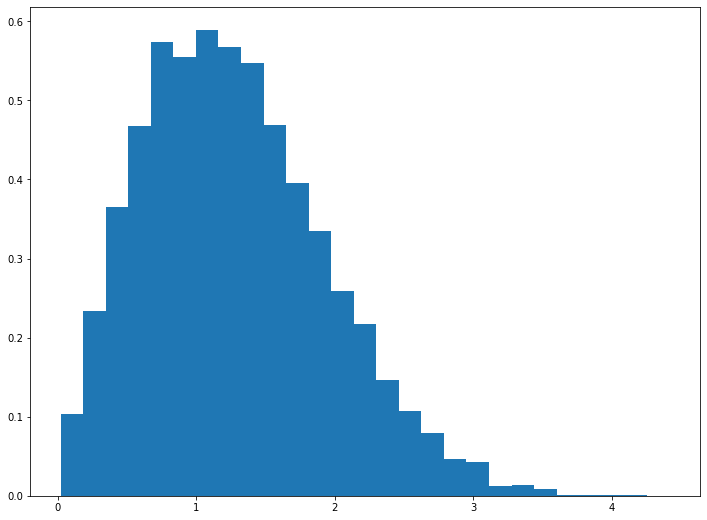

In [8]:
Snap_Vel = np.sqrt(np.sum(velocities*velocities,axis = 1) )### i will store speed in this array

#####  Function to compute time for wall collision ######
def wall_time(coord, velcomp, rad,L_box):  
    if velcomp > 0.0:
        del_t = (L_box - rad - coord) / velcomp
    elif velcomp < 0.0:
        del_t = (coord - rad) / abs(velcomp)
    else:
        del_t = float('inf')
    return del_t


# Function to calculate time it takes for a pair of atoms to collide. 
# pos1 and pos2 are positions of atoms 1 and 2, vel1 and vel2 are their 
# velocities. rad is the radius of the atoms. 
def pair_time(pos1, vel1, pos2, vel2, rad):  
    rel_pos = pos2 - pos1
    rel_vel = vel2 - vel1
    rel_dist_squar = np.dot(rel_pos,rel_pos)
    rel_speed_squar = np.dot(rel_vel,rel_vel)
    scal_prod = np.dot(rel_pos,rel_vel)
    a = scal_prod ** 2 - rel_speed_squar * ( rel_dist_squar - 4.0 * rad **2)
    if a > 0.0 and scal_prod < 0.0: ## Conditions for collision.
        del_t = - (scal_prod + np.sqrt(a)) / rel_speed_squar ## Collision time.
    else:
        del_t = float('inf')
    return del_t

T0 = 0  ##its  the remainder

##the function i created for taking snapshots after dt
def Snap_Function(next_event,T0,velocities,Snap_Vel):
    
    if (dtm < next_event and T0==0): ##For zero remainder
        t = 0
        while(t<next_event):
            t += dtm
            Snap_Vel = np.hstack((Snap_Vel,np.sqrt(np.sum(velocities*velocities,axis = 1)))) #colleting speed
        k12 = next_event-t
        T0 = dtm-k12  ##remainder
        
    elif(dtm < next_event and T0>0):
        Snap_Vel = np.hstack((Snap_Vel,np.sqrt(np.sum(velocities*velocities,axis = 1)))) #colleting speed
        t = T0
        while(t<next_event):
            t += dtm    
            Snap_Vel = np.hstack((Snap_Vel,np.sqrt(np.sum(velocities*velocities,axis = 1))))
        k12 = next_event-t
        T0 = dtm-k12    
     
    elif(dtm>next_event and T0< next_event):
        Snap_Vel = np.hstack((Snap_Vel,np.sqrt(np.sum(velocities*velocities,axis = 1))))
        k12  = next_event-T0
        T0 = dtm-k12
    else:
        T0 = T0-next_event 
    return Snap_Vel,T0;

    

pairs = [[i,j] for i in range(Natoms) for j in range(i+1, Natoms)] 
Datm = 2*Ratom ##diameter of disk
n_events = n_events_wd.value  ##it will get' value of n_event from slider
t = 0.0 # Initial time.


########################
########calculating mean free path
Vrms = np.sum(velocities**2,axis = 1)
Vrms = np.average(Vrms)
dtm = 1/((np.sqrt(2))*np.pi*Natoms*Datm*Datm*Vrms)##mean free path
dtm  = 0.07*dtm    ###taking sampling time to be a fraction of mean-free-path



############# Event Loop ##############################################
for event in tqdm(range(n_events)):
  
    wall_times = [wall_time(positions[i,j], velocities[i][j], Ratom,L_box) for i in range(Natoms) for j in range(2)] 
    # Pair collision times
    pair_times = [pair_time(positions[i], velocities[i], positions[j], velocities[j], Ratom) for i,j in pairs] 
    # The next collision event is the minimum of wall and pair collision times.

    next_event = min(wall_times + pair_times)  



    Snap_Vel,T0 = Snap_Function(next_event,T0,velocities,Snap_Vel)


    positions += velocities*next_event # Evolve positions to collision event

    if (min(wall_times) < min(pair_times)): # Check if next event is a collision with a wall
        wall_index = wall_times.index(next_event)
        particle, component = wall_index/2, wall_index%2
        velocities[int(particle),int(component)] *= -1.0 ## Velocity component normal to wall changes sign
    else:
        pair_index = pair_times.index(next_event)
        particle_1, particle_2 = pairs[pair_index] # Indices of atoms participating in collision.
        rel_pos = positions[particle_2] - positions[particle_1]
        rel_vel = velocities[particle_2] - velocities[particle_1]
        distance = np.sqrt(np.dot(rel_pos,rel_pos))
        unit_perp = rel_pos/distance
        scal_prod = np.dot(rel_vel,unit_perp)
        velocities[particle_1] += scal_prod*unit_perp # Change in velocities of atoms colliding with each other
        velocities[particle_2] -= scal_prod*unit_perp


plt.figure(figsize = (12,9))                                                                                            


plt.hist(Snap_Vel,bins  = 27,density=True)

plt.show()        